Part 1: Models
==============

At the heart of model-fitting is the model: a set of equations, numerical processes and assumptions describing a
physical system of interest. The goal of model-fitting is to understand this physical system more, ultimately
develop more complex models which describe more aspects of the system more accurately.

In Astronomy, a model may describe the distribution of stars within a galaxy. In biology, is may describe the
interaction of proteins within a cell. In finance, it may describe the evolution of stock prices in a market.
Your model depends on your topic of study, but in all cases the model acts as the mathematical description of
some physical system you seek understand better, and hope ultimately to make new predictions of.

Whatever your model, the equations that underpin will be defined by "free parameters". Changing these parameters
changes the prediction of the model.

For example, an Astronomy model of the distribution of stars may contain a
parameter describing the brightness of the stars, a second parameter defining their number density and a third
parameter describing their colors. If we multiplied the parameter describribing the brightness of the stars by 2,
the stars would therefore appear twice as bright.

Once the model (e.g. the undrlying equations) is defined and a values for the free parameters have been chosen, the
model can create "model data". This data is a realization of how the physical system appears for that model with
those parameters.

For example, a model of the distribution of stars within a galaxy can be used to create a model image of that galaxy.
By changing the parameters governing the distribution of stars, it can produce many different model images, with
different brightness, colors, sizes, etc.

In this tutorial, we will learn the basics of defining a model, and we will in particular:

 - Define a simple model, described by few single equations.

 - Show that this model is described by 3 or more free parameters.

 - Use the model, with different sets of parameters, to generate model data.

This will all be performed using the **PyAutoFit** API for model composition, which forms the basis of all model
fitting performed by **PyAutoFit**.

In [55]:
import numpy as np
import matplotlib.pyplot as plt

import autofit as af

__Paths__

**PyAutoFit** assumes the current working directory is `/path/to/autofit_workspace/` on your hard-disk (or in Binder). 

This is so that it can:

 - Load configuration settings from config files in the `autofit_workspace/config` folder.

 - Load example data from the `autofit_workspace/dataset` folder.

 - Output the results of models fits to your hard-disk to the `autofit/output` folder. 

If you don't have an `autofit_workspace` (perhaps you cloned / forked the **PyAutoFit** GitHub repository?) you can
download it here:

 https://github.com/Jammy2211/autofit_workspace

At the top of every tutorial notebook, you will see the following cell. 

This cell uses the project `pyprojroot` to locate the path to the workspace on your computer and use it to set the 
working directory of the notebook.

In [56]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Model Parameterization__

A model is a set of equations, numerical processes and assumptions that describe a physical system and dataset.

We can pretty much consider anything is a model. In this example, our model will simply be one or more 1 dimensional
Gaussian, defined by the following equaiton:

\begin{equation*}
g(x, I, \sigma) = \frac{N}{\sigma\sqrt{2\pi}} \exp{(-0.5 (x / \sigma)^2)}
\end{equation*}

Where:

`x`: Is the x-axis coordinate where the `Gaussian` is evaluated.

`N`: Describes the overall normalization of the Gaussian.

$\sigma$: Describes the size of the Gaussian (Full Width Half Maximum = $\mathrm {FWHM}$ = $2{\sqrt {2\ln 2}}\;\sigma$)

Whilst a 1D Gaussian may seem like a somewhat rudimentary model, it actually has a lot of real-world applicaiton
in signal process, where 1D Gausians are fitted to 1D datasets in order to quantify the size of a signal. Our
model is therefore a realstic representation of a real world modeling problrem!

We therefore now have a model, which as expected is a set of equations (just one in this case) that describes a 
dataset.

The model has 3 parameters, $(x, N, \sigma)$, where using different combinations of these parameters creates different 
realizations of the model.

So, how do we compose this model is **PyAutoFit**?

__Model Composition__

To define a "model component" in **PyAutoFit** we simply write it as a Python class using the format shown below:

In [57]:


class Gaussian:
    def __init__(
            self,
            centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
            normalization=1.0,  # <- are the Gaussian`s model parameters.
            sigma=5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_1d_via_xvalues_from(self, xvalues: np.ndarray):
        """

        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


The format of this Python class defines how **PyAutoFit** will compose the `Gaussian` as a model, where:

- The name of the class is the name of the model component, in this case, "Gaussian".

- The input arguments of the constructor (the `__init__` method) are the parameters of the model, in the
  example above `centre`, `normalization` and `sigma`.

- The default values of the input arguments define whether a parameter is a single-valued `float` or a 
  multi-valued `tuple`. For the `Gaussian` class above, no input parameters are a tuple, but later examples use tuples. 

- It includes functions associated with that model component, specifically the `model_data_1d_via_xvalues_from` 
  function. When we create instances of a `Gaussian` below, this is used to generate 1D representation of it as a 
  NumPy array.

To compose a model using the `Gaussian` class above we use the `af.Model` object.

In [58]:
model = af.Model(Gaussian)
print("Model `Gaussian` object: \n")
print(model)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior [34], lower_limit = 0.0, upper_limit = 100.0), (normalization, LogUniformPrior [35], lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior [36], lower_limit = 0.0, upper_limit = 25.0)


The model has a total of 3 parameters:

In [59]:
print(model.total_free_parameters)

3


All model information is given by printing its `info` attribute.

This includes model parameters have priors, which are described fully in tutorial 3 of this chapter.

[The `info` below may not display optimally on your computer screen, for example the whitespace between parameter
names on the left and parameter priors on the right may lead them to appear across multiple lines. This is a
common issue in Jupyter notebooks.

The`info_whitespace_length` parameter in the file `config/general.yaml` in the [output] section can be changed to 
increase or decrease the amount of whitespace (The Jupyter notebook kernel will need to be reset for this change to 
appear in a notebook).]

In [60]:
print(model.info)

Total Free Parameters = 3

model                                                                           Gaussian (N=3)

centre                                                                          UniformPrior [34], lower_limit = 0.0, upper_limit = 100.0
normalization                                                                   LogUniformPrior [35], lower_limit = 1e-06, upper_limit = 1000000.0
sigma                                                                           UniformPrior [36], lower_limit = 0.0, upper_limit = 25.0


__Model Mapping__

Instances of model components created via the `af.Model` object can be created, where an input `vector` of
parameters is mapped to the Python class the model object was created using.

We first need to know the order of parameters in the model, so we know how to define the input `vector`. This
information is contained in the models `paths` attribute:

In [61]:
print(model.paths)
print(model.parameter_names)

[('centre',), ('normalization',), ('sigma',)]
['centre', 'normalization', 'sigma']


We input values for the 3 free parameters of our model following the order of paths 
above (`centre=30.0`, `normalization=2.0` and `sigma=3.0`), creating an `instance` of the `Gaussian` via the model.

In [62]:
instance = model.instance_from_vector(vector=[30.0, 2.0, 3.0])

This is an instance of the `Gaussian` class.

In [63]:
print("Model Instance: \n")
print(instance)

Model Instance: 



It has the parameters of the `Gaussian` with the values input above.

In [64]:
print("Instance Parameters \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

Instance Parameters 

x =  30.0
normalization =  2.0
sigma =  3.0


We can use functions associated with the class, specifically the `model_data_1d_via_xvalues_from` function, to 
create a realization of the `Gaussian` and plot it.

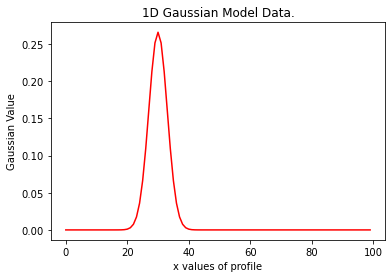

<Figure size 432x288 with 0 Axes>

In [65]:
xvalues = np.arange(0.0, 100.0, 1.0)

model_data = instance.model_data_1d_via_xvalues_from(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian Model Data.")
plt.xlabel("x values of profile")
plt.ylabel("Gaussian Value")
plt.show()
plt.clf()

__More Complex Models__

The code above seemed like a lot of work just to create an instance of the `Guassian` class. Couldn't we have
just done the following instead?

 `instance = Gaussian(centre=30.0, normalization=2.0, sigma=3.0)`.

Yes, we could have. 

However, the model composition API used above is designed to make composing complex models, made of multiple 
components with many free parameters, straightforward and scalable.

To illustrate this, lets end the tutorial by composing a model made of multiple Gaussians and also another 1D
profile, an Exponential, which is defined following the equation:

\begin{equation*}
g(x, I, \lambda) = N \lambda \exp{- \lambda x }
\end{equation*}

Where:

`x`: Is the x-axis coordinate where the `Exponential` is evaluated.

`N`: Describes the overall normalization of the `Exponential`

$\lambda$: Describes the rate of decay of the exponential.

We first define the `Exponential` using the same format as above. 

In [66]:


class Exponential:
    def __init__(
            self,
            centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
            normalization=1.0,  # <- are the Gaussian`s model parameters.
            rate=0.01,
    ):
        """
        Represents a 1D Exponential profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        ratw
            The decay rate controlling has fast the Exponential declines.
        """
        self.centre = centre
        self.normalization = normalization
        self.rate = rate

    def model_data_1d_via_xvalues_from(self, xvalues: np.ndarray):
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.normalization * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )


We can easily compose a model consisting of 1 `Gaussian` object and 1 `Exponential` object using the `af.Collection`
object:

In [67]:
model = af.Collection(gaussian=af.Model(Gaussian), exponential=af.Model(Exponential))

All of the information about the model created via the collection can be printed at once using its `info` attribute:

In [68]:
print(model.info)

Total Free Parameters = 6

model                                                                           Collection (N=6)
    gaussian                                                                    Gaussian (N=3)
    exponential                                                                 Exponential (N=3)

gaussian
    centre                                                                      UniformPrior [37], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [38], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [39], lower_limit = 0.0, upper_limit = 25.0
exponential
    centre                                                                      UniformPrior [40], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [41],

Because the `Gaussian` and `Exponential` are being passed to a `Collection` they are automatically 
assigned as `Model` objects.

We can therefore omit the `af.Model` method when passing classes to a `Collection`, making the Python code more
concise and readable.

In [69]:
model = af.Collection(gaussian=Gaussian, exponential=Exponential)

The `model.info` appears identical to the previous example.

In [70]:
print(model.info)

Total Free Parameters = 6

model                                                                           Collection (N=6)
    gaussian                                                                    Gaussian (N=3)
    exponential                                                                 Exponential (N=3)

gaussian
    centre                                                                      UniformPrior [43], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [44], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [45], lower_limit = 0.0, upper_limit = 25.0
exponential
    centre                                                                      UniformPrior [46], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [47],

A `Collection` behaves analogous to a `Model`, but it contains a multiple model components.

We can see this by printing its `paths` attribute, where paths to all 6 free parameters via both model components
are shown.

The reason the paths have the entries `.gaussian.` and `.expoential.` is becuase these are the names we input into 
the `af.Collection` object above. If you change the input from `gaussian=` to `gaussian_edited=` this will be reflected 
in the `paths` below.

In [71]:
print(model.paths)

[('gaussian', 'centre'), ('gaussian', 'normalization'), ('gaussian', 'sigma'), ('exponential', 'centre'), ('exponential', 'normalization'), ('exponential', 'rate')]


A model instance can again be created by mapping an input `vector`, which now has 6 entries.

In [72]:
instance = model.instance_from_vector(vector=[0.1, 0.2, 0.3, 0.4, 0.5, 0.01])

This `instance` contains each of the model components we defined above, using the input argument name of the
`Collection` to define the attributes in the `instance`:

In [73]:
print("Instance Parameters \n")
print("x (Gaussian) = ", instance.gaussian.centre)
print("normalization (Gaussian) = ", instance.gaussian.normalization)
print("sigma (Gaussian) = ", instance.gaussian.sigma)
print("x (Exponential) = ", instance.exponential.centre)
print("normalization (Exponential) = ", instance.exponential.normalization)
print("sigma (Exponential) = ", instance.exponential.rate)

Instance Parameters 

x (Gaussian) =  0.1
normalization (Gaussian) =  0.2
sigma (Gaussian) =  0.3
x (Exponential) =  0.4
normalization (Exponential) =  0.5
sigma (Exponential) =  0.01


In the context of the equations that define the model, the model is simply the sum of the two equations that define
the `Gaussian` and `Exponential`.

Generating the `model_data` therefore requires us to simply sum each individual model component`s `model_data`, which
we do and visualize below.

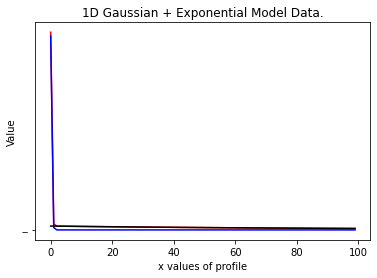

<Figure size 432x288 with 0 Axes>

In [74]:
xvalues = np.arange(0.0, 100.0, 1.0)

model_data_0 = instance.gaussian.model_data_1d_via_xvalues_from(xvalues=xvalues)
model_data_1 = instance.exponential.model_data_1d_via_xvalues_from(xvalues=xvalues)

model_data = model_data_0 + model_data_1

plt.plot(xvalues, model_data, color="r")
plt.plot(xvalues, model_data_0, "b", "--")
plt.plot(xvalues, model_data_1, "k", "--")
plt.title("1D Gaussian + Exponential Model Data.")
plt.xlabel("x values of profile")
plt.ylabel("Value")
plt.show()
plt.clf()

__Extensibility__

It is hopefully now clear why we use `Model` and `Collection` objects to compose our model.

They can easily be extended to compose complex models with many components and parameters. For example, we could
input more `Gaussian` and `Exponential` components into the `Collection`, or we could write new Python classes
that represent new model components with more parameters.

These objects serve many other key purposes that we will cover in later tutorials, 

__Wrap Up__

In this tutorial, we introduced how to define and compose a model, which we can generate model data from. 

To end, have a think about your particular field of study and the problem you are hoping to solve through 
model-fitting., What is the model you might want to fit? What Python class using the format above are requird to
compose the right model? What are the free parameters of you model?

If you decide to add a new model-component to the `autofit_workspace` specific to your model-fitting task, first
checkout the following script, which explains how to set up the **PyAutoFit** configuration files associated with 
your model.

`autofit_workspace/*/overview/new_model_component/new_model_component.ipynb`

Below are two more example Python classes one might define to perform model fitting, the first is the model of a 
linear-regression line of the form $y = mx + c$ that you might fit to a 1D data-set:

In [75]:


class LinearFit:
    def __init__(self, gradient=1.0, intercept=0.0):
        self.gradient = gradient
        self.intercept = intercept


The second example is a two-dimensional Gaussian. Here, the centre now has two coordinates (y,x), which in 
**PyAutoFit** is more suitably defined using a tuple.

In [76]:


class Gaussian2D:
    def __init__(self, centre=(0.0, 0.0), normalization=0.1, sigma=1.0):
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma


Part 2: Fitting Data
====================

We have now learnt that a model is a set of equations, numerical processes and assumptions describing
a physical system. We defined a couple of simple models made of 1D equations like a Gaussian, composed them as models
in **PyAutoFit** using the `Model` and `Collection` objects, and used these models to create model data for different
values of their parameters.

For our model to inform us about a real physical system, we need to fit it to data. By fitting it to the data,
we can determine whether the model provides a good or bad fit to the data. If it is a good fit, we will learn which
parameter values best describe the data and therefore the physical system as a whole. If it is a bad fit, we will
learn that our model is not representative of the physical system and therefore that we need to change it.

The process of defining a model, fitting it to data and using it to learn about the system we are modeling is at the
heart of model-fitting. One would typically repeat this process many times, making the model more complex to better
fit more data, better describing the physical system we are interested in.

In Astronomy, this is the process that was followed to learn about the distributions of stars in galaxies. Fitting
high quality images of galaxies with ever more complex models, allowed astronomers to determine that the stars in
galaxies are distributed in structures like disks, bars and bulges, and it taught them that stars appear differently
in red and blue images due to their age.

In this tutorial, we will learn how to fit the `model_data` created by a model to data, and we will in particular:

 - Load data of a 1D Gaussian signal which is the data we will fit.

 - Subtract the model data from the data to compute quantities like the residuals of the fit.

 - Quantify the goodness-of-fit of a model to the data quantitatively using a key quantity in model-fitting called the
   `log_likelihood`.

This will all be performed using the **PyAutoFit** API for model composition, which forms the basis of all model
fitting performed by **PyAutoFit**.

In [77]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
from os import path
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Data__

Our data is noisy 1D data containing a signal, where the underlying signal is generated using the equation of 
a 1D Gaussian, a 1D Exponential or a sum of multiple 1D profiles.
 
We now load this data from .json files, where:

 - The `data` is a 1D numpy array of values corresponding to the observed signal.
 - The `noise_map` is a 1D numpy array of values corresponding to the estimate noise value in every data point.
 
These datasets are created via the scripts `autofit_workspace/howtofit/simulators`, feel free to check them out!

In [78]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))

noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

We now plot the 1D signal via `matplotlib`.

The 1D signal is observed on uniformly spaced `xvalues`, which are computed using the `arange` function 
and `data.shape[0]` method.

These x values will be used again below, when we create model data from the model.

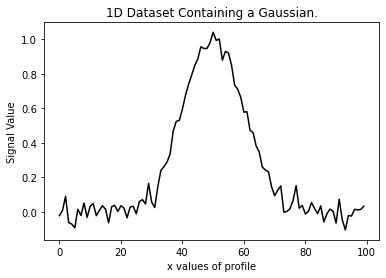

In [79]:
xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Dataset Containing a Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()

The plot above only showed the signal, and did not show the noise estimated in every data point. 

We can plot the signal, including its `noise_map`, using the `matplotlib` `errorbar` function. 

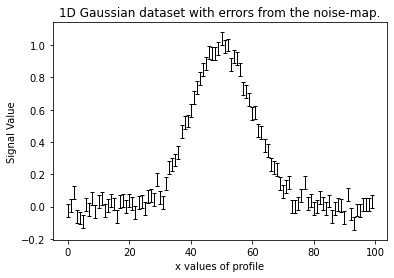

In [80]:
plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2, linestyle=" ",
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()


__Model Data__

How do we actually fit our `Gaussian` model to this data? First, we generate `model_data` of the 1D `Gaussian` model,
following the same steps as the previous tutorial. 

In [81]:


class Gaussian:
    def __init__(
        self,
        centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization=1.0,  # <- are the Gaussian`s model parameters.
        sigma=5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_1d_via_xvalues_from(self, xvalues: np.ndarray):
        """

        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


We can use this model to create `model_data` of the `Gaussian` by passing it an input `xvalues` of the observed
data.

We do this below, and plot the resulting model-data.

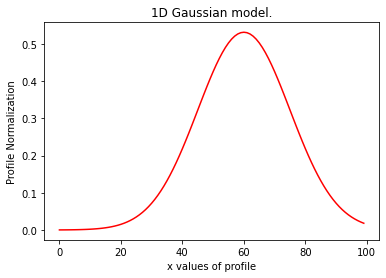

<Figure size 432x288 with 0 Axes>

In [82]:
model = af.Model(Gaussian)

gaussian = model.instance_from_vector(vector=[60.0, 20.0, 15.0])

model_data = gaussian.model_data_1d_via_xvalues_from(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian model.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

It is often more informative to plot the `data` and `model_data` on the same plot for comparison.

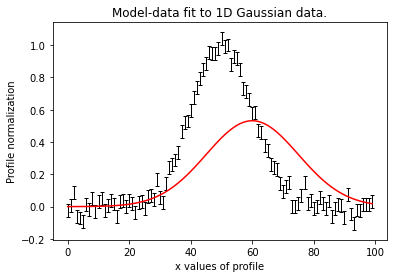

In [83]:
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2, linestyle=" ",
)
plt.plot(xvalues, model_data, color="r")
plt.title("Model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

Different values of `centre`, `normalization` and `sigma` change the `Gaussian``s appearance. 

Have a go at editing some of the values input into `instance_from_vector()`, recomputing the `model_data` and
plotting it above to see this behaviour.

__Residuals__

The comparison of the `data` and `model_data` above is informative, but it can be more useful to show the
residuals, which are calculated as `data - model_data` in 1D:

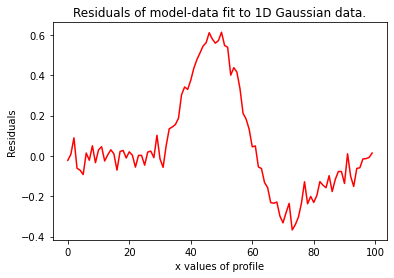

<Figure size 432x288 with 0 Axes>

In [84]:
residual_map = data - model_data
plt.plot(xvalues, residual_map, color="r")
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

Are these residuals a good fit to the data? Without considering the noise in the data, we can't be sure.

We can plot the residual-map with error-bars for the noise-map, which below shows that the model is a pretty bad fit,
because many of the residuals are far away from 0 even after accounting for the noise in every data point.

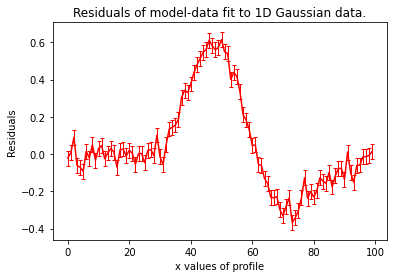

<Figure size 432x288 with 0 Axes>

In [85]:
residual_map = data - model_data
plt.errorbar(
    x=xvalues,
    y=residual_map,
    yerr=noise_map,
    color="r",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
plt.title("Residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.show()
plt.clf()

__Normalized Residuals__

A different way to quantify and visualize how good (or bad) the fit is, is using the normalized residual-map (sometimes
called the standardized residuals).

This is defined as the residual-map divided by the noise-map. 

If you are familiar with the concept of `sigma` variancdes in statistics, the normalized residual-map is equivalent
to the number of `sigma` the residual is from zero. For example, a normalized residual of 2.0 (which has confidence
internals for 95%) means that the probability that the model under-estimates the data by that value is just 5.0%.

The residual map with error bars and normalized residual map portray the same information, but the normalized
residual map is better for visualization for problems with more than 1 dimension, as plotting the error bars in
2D or more dimensions is not straight forward.

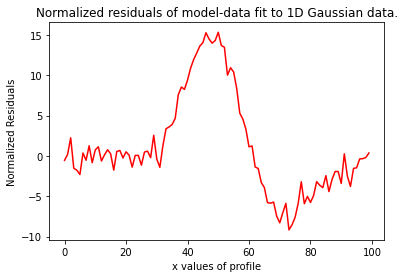

<Figure size 432x288 with 0 Axes>

In [86]:
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="r")
plt.title("Normalized residuals of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals")
plt.show()
plt.clf()

__Chi Squared__

We now define the `chi_squared_map`, which is the `normalized_residual_map` squared, and will be used to compute the
the final goodness of fit measure.

The normalized residual map has both positive and negative values. When we square it, we therefore get only positive
values. This means that a normalized residual of -0.2 and 0.2 both become 0.04, and therefore in the context of a
`chi_squared` signify the same goodness-of-fit.

Again, it is clear that the model gives a poor fit to the data.

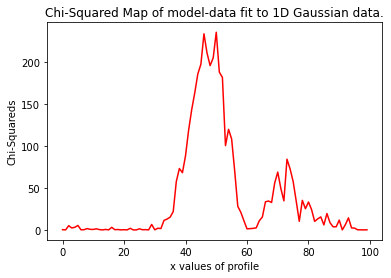

<Figure size 432x288 with 0 Axes>

In [87]:
chi_squared_map = (normalized_residual_map) ** 2
plt.plot(xvalues, chi_squared_map, color="r")
plt.title("Chi-Squared Map of model-data fit to 1D Gaussian data.")
plt.xlabel("x values of profile")
plt.ylabel("Chi-Squareds")
plt.show()
plt.clf()

we now reduce all the information in our `chi_squared_map` into a single goodness-of-fit measure by defining the 
`chi_squared`: the sum of all values in the `chi_squared_map`.

This is why having all positive and negative values in the normalized residual map become positive is important,
as this summed measure would otherwise cancel out the positive and negative values.

In [88]:
chi_squared = np.sum(chi_squared_map)
print("Chi-squared = ", chi_squared)

Chi-squared =  3944.4121288266556


The lower the chi-squared, the fewer residuals in the model's fit to the data and therefore the better our fit as
a whole!

__Noise Normalization__

We now define a second quantity that will enter our final quantification of the goodness-of-fit, called the
`noise_normalization`.

This is the log sum of all noise values squared in our data. Given the noise-map is fixed, the `noise_normalization`
retains the same value for all models that we fit, and therefore could be omitted. Nevertheless, its good practise
to include it as it has an important meaning statistically.

Lets not worry about what a `noise_normalization` actually means, because its not important for us to successfully
get a model to fit a dataset. In a nutshell, it relates the noise in the dataset being drawn from a Gaussian
distribution.

In [89]:
noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))

__Likelihood__

From the `chi_squared` and `noise_normalization` we can define a final goodness-of-fit measure, the `log_likelihood`. 

This is the sum of the `chi_squared` and `noise_normalization` multiplied by -0.5. Why -0.5? Again, lets not worry
about this for now.

In [90]:
log_likelihood = -0.5 * (chi_squared + noise_normalization)
print("Log Likelihood = ", log_likelihood)

Log Likelihood =  -1742.212335246975


Above, we stated that a lower `chi_squared` corresponds to a better model-data fit. 

When computing the `log_likelihood` we multiplied the `chi_squared` by -0.5. Therefore, a higher log likelihood
corresponds to a better model fit, as one would hope!

__Fitting Functions__

If you are familiar with model-fitting, you'll have probably heard of terms like 'residuals', 'chi-squared' and
'log_likelihood' before. These are the standard metrics by which a model-fit`s quality is quantified. They are used for
model fitting in general, so not just when your data is 1D but when its a 2D image, 3D datacube or something else
entirely!

If you have not performed model fitting before and these terms are new to you, make sure you are clear on exactly what
they all mean as they are at the core of all model-fitting performed in **PyAutoFit** (and statistical inference in
general)!

Lets recap everything we've learnt so far:
    
 - We can define a model, like a 1D `Gaussian`, using Python classes that follow a certain format.
 
 - The model can be set up as a `Collection` and `Model`, having its parameters mapped to an instance of the
   model class (e.g the `Gaussian`).  

 - Using this model instance, we can create model-data and compare it to data and quantify the goodness-of-fit via a 
   log likelihood.

We now have everything we need to fit our model to our data! 

So, how do we go about finding the best-fit model? That is, what model which maximizes the log likelihood?

The most simple thing we can do is guess parameters. When we guess parameters that give a good fit (e.g. a higher 
log likelihood), we then guess new parameters with values near those previous vlaues. We can repeat this process, 
over and over, until we find a really good model!

For a 1D  `Gaussian` this works pretty well. Below, we fit 3 different `Gaussian` models and end up landing on
the best-fit model (the model I used to create the dataset in the first place!).

For convenience, I've create functions which compute the `log_likelihood` of a model-fit and plot the data and model
data with errors.

In [91]:


def log_likelihood_from(data, noise_map, model_data):
    residual_map = data - model_data
    normalized_residual_map = residual_map / noise_map
    chi_squared_map = (normalized_residual_map) ** 2
    chi_squared = sum(chi_squared_map)
    noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))
    log_likelihood = -0.5 * (chi_squared + noise_normalization)

    return log_likelihood


def plot_model_fit(xvalues, data, noise_map, model_data, color="k"):
    plt.errorbar(
        x=xvalues,
        y=data,
        yerr=noise_map,
        color=color,
        ecolor="k",
        linestyle=" ",
        elinewidth=1,
        capsize=2,
    )
    plt.plot(xvalues, model_data, color="r")
    plt.title("Fit of model-data to data.")
    plt.xlabel("x values of profile")
    plt.ylabel("Profile Value")
    plt.show()
    plt.clf()


__Guess 1__

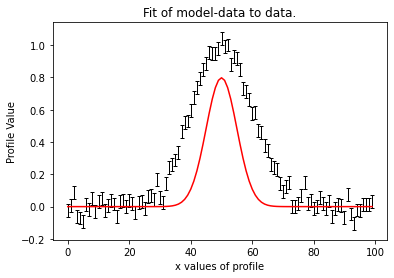

Log Likelihood: -1505.8871672459425


<Figure size 432x288 with 0 Axes>

In [92]:

gaussian = model.instance_from_vector(vector=[50.0, 10.0, 5.0])
model_data = gaussian.model_data_1d_via_xvalues_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Guess 2__

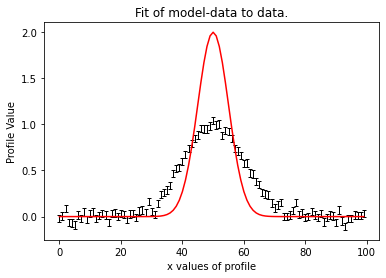

Log Likelihood: -2390.965918405071


<Figure size 432x288 with 0 Axes>

In [93]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 5.0])
model_data = gaussian.model_data_1d_via_xvalues_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Guess 3__

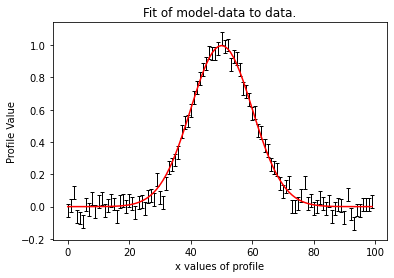

Log Likelihood: 175.74244719714878


<Figure size 432x288 with 0 Axes>

In [94]:

gaussian = model.instance_from_vector(vector=[50.0, 25.0, 10.0])
model_data = gaussian.model_data_1d_via_xvalues_from(xvalues=xvalues)
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")

__Extensibility__

Fitting models made of multiple components is straight forward. 

We again simply create the model via  the `Collection` object, use it to generate `model_data` and fit it to the 
data in order to compute the log likelihood.

In [95]:
model = af.Collection(gaussian_0=Gaussian, gaussian_1=Gaussian)

instance = model.instance_from_vector(vector=[40.0, 0.2, 0.3, 60.0, 0.5, 1.0])

model_data_0 = instance.gaussian_0.model_data_1d_via_xvalues_from(xvalues=xvalues)
model_data_1 = instance.gaussian_1.model_data_1d_via_xvalues_from(xvalues=xvalues)

model_data = model_data_0 + model_data_1

We plot the data and model data below, showing that we get a bad fit (a low log likelihood) for this model.

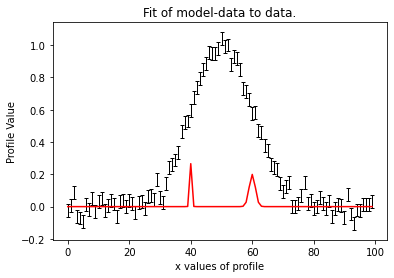

Log Likelihood: -5080.485468281931


<Figure size 432x288 with 0 Axes>

In [96]:
plot_model_fit(
    xvalues=xvalues,
    data=data,
    noise_map=noise_map,
    model_data=model_data,
    color="r",
)

log_likelihood = log_likelihood_from(
    data=data, noise_map=noise_map, model_data=model_data
)
print(f"Log Likelihood: {log_likelihood}")


When the model had just 3 parameters, it was feasible to guess values by eye and find a good fit. 

With six parameters, this approach becomes inefficient, and doing it with even more parameters would be impossible!

In the next turorial, we will learn a more efficient and automated approach for fitting models to data.

__Wrap Up__

To end, have another quick think about the model you ultimately want to fit with **PyAutoFit**. What does the
data look like? Is it one dimension? two dimensions? Can you easily define a model which generates realizations of
this data? Can you picture what a residual map would look like and how you would infer a log likelihood from it?

If not, don't worry about it for now, because you first need to learn how to fit a model to data using **PyAutoFit**.

Part 3: Non Linear Search
=========================

In the previous tutorials, we defined a model and fitted it to data via fitting functions. We quantified the goodness
of fit via the log likliehood and showed that for models with only a few free parameters, we could find good fits to
the data by manually guessing parameter values. However, for more complex models, this approach was infeasible.

In this tutorial, we will learn how to fit the model to data properly, using a technique that can scale up to
models with 10s or 100s of parameters.

__Parameter Space__

In mathematics, we can write a function as follows:

$f(x) = x^2$

In this function, when we input the parameter $x$ in to the function $f$, it returns a value $f(x)$.

This mapping between values of $x$ and $f(x)$ define the "parameter space" of this function (which fot
the function $f(x) = x^2$ is a parabola).

A function can have multiple parameters, for 3 parameters, $x$, $y$ and $z$:

$f(x, y, z) = x + y^2 - z^3$

The mapping between values of $x$, $y$ and $z$ and $f(x, y, z)$ define another parameter space, albeit it now
has 3 dimensions.

The concept of a parameter space relates closely to how in the previous tutorial we use instances of a 1D Gaussian
profile, with parameters $(x, I, \sigma)$ to fit data with a model and compute a log likelihood.

This process can be thought of as a function $f (x, I, \sigma)$, where the value returned by this function is the
log likelihood.

With that, we have introduced one of the most important concepts in model-fitting,
the "log likelihood function". This function describes how we use an instance of the model (e.g. where the
parameters have values) to compute a log likelihood describing good of a fit to the data it is.

We can write this log likelihood function as follows:

$f(x, N, \sigma) = log_likelihood$

By expressing the likelihood in this way, we can therefore now think of our model as having a parameter space. This
parameter space consists of an N dimensional surface (where N is the number of free parameters) spanning all possible
values of model parameters. This surface itself can be considered the "likelihood surface", and finding the peak of
this surface is our goal when we perform model-fitting.

This parameter space is "non-linear", meaning that the relationship between input parameters and log likelihood does
not behave linearly. This simply means that it is not possible to predict what a log likelihood will be from a set of
model parameters, unless a whole fit to the data is performed in order to compute the value.

__Non Linear Search__

Now that we are thinking about the problem in terms of a non-linear parameter space with a likelihood surface, we can
now introduce the method used to fit the model to the data, the "non-linear search".

Previously, we tried a basic approach, randomly guessing models until we found one that gave a good fit and
high `log_likelihood`. Surprisingly, this is the basis of how model fitting using a non-linear search actually works!

The non-linear search guesses lots of models, tracking the log likelihood of these models. As the algorithm
progresses, it preferentially tries more models using parameter combinations that gave higher log likelihood solutions
previously. The rationale is that if a parameters set provided a good fit to the data, models with similar values will
too.

There are two key differences between guessing random models to find a good fit and a non-linear search:

 - The non-linear search fits the model to the data in mere miliseconds. It therefore can compute the log likelihood
   of tens of thousands of different model parameter combinations in order to find the highest likelihood solutions.
   This would have been impractical for a human.

 - The non-linear search has a much better tracking system to remember which models it guess previously and what
   their log likelihoods were. This means it can sample all possible solutions more thoroughly, whilst honing in on
   those which give the highest likelihood more quickly.

We can think of our non-linear search as "searching" parameter space, trying to find the regions of parameter space
with the highest log likelihood values. Its goal is to find them, and then converge on the highest log likelihood
solutions possible. In doing so, it can tell us what model parameters best-fit the data.

This picture of how a non-linear search is massively simplified, and omits key details on how statistical principles
are upheld to ensure that results are statistically robust. The goal of this chapter is to teach you how to fit a
model to data, not the underlying principles of Bayesian inference on which model-fitting is based.

If you are interested, more infrmation can be found at the following web links:

https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50

__MCMC__

There are many different non-linear search algorithms, which search parameter space in different ways. This tutorial
uses a a Markov Chain Monte Carlo (MCMC) method alled `Emcee`. For now, lets not worry about the details of how
an MCMC method actually works, and just use the simplified picture we painted above.

In [97]:
import autofit as af
import autofit.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Data__

Load and plot the dataset from the `autofit_workspace/dataset` folder.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


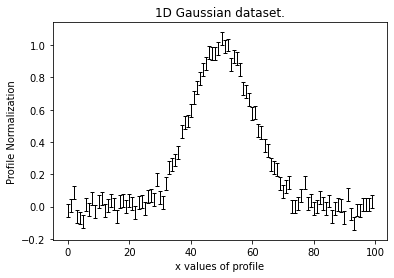

<Figure size 432x288 with 0 Axes>

In [98]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
print(xvalues)

plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", linestyle=" ", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Normalization")
plt.show()
plt.clf()

__Model__

Lets again define our 1D `Gaussian` model. 

In [99]:


class Gaussian:
    def __init__(
            self,
            centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
            normalization=1.0,  # <- are the Gaussian`s model parameters.
            sigma=5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_1d_via_xvalues_from(self, xvalues: np.ndarray):
        """

        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


We now compose our model, a single 1D Gaussian, which we will fit to the data via the non-linear search.

In [100]:
model = af.Model(Gaussian)

print(model.info)

Total Free Parameters = 3

model                                                                           Gaussian (N=3)

centre                                                                          UniformPrior [58], lower_limit = 0.0, upper_limit = 100.0
normalization                                                                   LogUniformPrior [59], lower_limit = 1e-06, upper_limit = 1000000.0
sigma                                                                           UniformPrior [60], lower_limit = 0.0, upper_limit = 25.0


__Priors__

When we print its `.info`, we see that the parameters have priors (e.g. `UniformPrior`). We have so far not worried 
about what these meant, but now we understand how a non-linear search works we can now discuss what priors are.

A parameter, for example the `centre` of the `Gaussian`, could take any value between negative and positive infinity. 
However, when we inspect the data it is clearly confined to values between 0.0 and 100.0. Our model parameter space 
should reflect this, and only contain solutions with these physically plausible values between 0.0 --> 100.0.

One role of priors is to define where parameter space has valid solutions. The `centre` parameter has 
a `UniformPrior` with a  `lower_limit=0.0` and `upper_limit=100.0`. It therefore is already confined to the values 
discussed above.

Priors have a second role: they encode our previous beliefs about a model and what values we expect the parameters 
to have. 

For example, imagine we had multiple datasets observing the same signal and we had already fitted the model to the 
first signal already. We may set priors that reflect this result, as we have prior knowledge of what the parameters
will likely be. 

Setting priros in this way actually changes the result inferred when fitting the second dataset, because the priors 
partly constrain the result based on the information learned in the first fit. Other types of priors you will 
see throughout the autofit workspace (e.g `GaussianPrior`, `LogUniformPrior`) allow one to encode this type of 
information in a fit..

In this tutorial, we will stick to uniform priors, as they are conceptually the most simple.

Lets manually set the priors of the model we fit in this example.

In [101]:
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.normalization = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)
model.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=10.0)

__Analysis__

The non-linear search requires an `Analysis` class, which:

 1) Receives the data that the model fits.

 2) Defines the `log_likelihood_function`, which computes a `log_likelihood` from a model instance. 

 3) Provides an interface between the non-linear search and the `log_likelihood_function`, so the search can determine
    the goodness of fit of any set of model parameters.

The non-linear search calls the `log_likelihood_function` many times, enabling it map out the high likelihood regions 
of parameter space and converges on the highest log likelihood solutions.

Below is a suitable `Analysis` class for fitting a 1D gaussian to the data loaded above.

In [102]:


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):
        """
        In this example the `Analysis` object only contains the `data` and `noise-map`.

        It can be easily extended, for more complex data-sets and model fitting problems.

        Parameters
        ----------
        data
            A 1D numpy array containing the data (e.g. a noisy 1D Gaussian) fitted in the workspace examples.
        noise_map
            A 1D numpy array containing the noise values of the data, used for computing the goodness of fit
            metric.
        """
        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):
        """
        Returns the log likelihood of a fit of multiple 1D Gaussians to the dataset.

        The `instance` that comes into this method is an instance of the `Gaussian` model above. The parameter values
        are chosen by the non-linear search, based on where it thinks the high likelihood regions of parameter
        space are.

        The lines of Python code are commented out below to prevent excessive print statements when we run the
        non-linear search, but feel free to uncomment them and run the search so you can see all the models it tries.

        print("Gaussian Instance:")
        print("Centre = ", instance.centre)
        print("Normalization = ", instance.normalization)
        print("Sigma = ", instance.sigma)

        We fit the data with the `Gaussian` instance, using its "model_data_1d_via_xvalues_from" function to create the
        model data.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.model_data_1d_via_xvalues_from(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood


We create an instance of the `Analysis` class by simply passing it the `data` and `noise_map`:

In [103]:
analysis = Analysis(data=data, noise_map=noise_map)

__Search__

To use the non-linear search `Emcee` we simply create an instance of the `af.Emcee` object and pass the analysis
and model to its `fit` method.

In [104]:
model = af.Model(Gaussian)

search = af.Emcee(name="session_1")

2023-07-03 11:21:29,566 - autofit.non_linear.abstract_search - INFO - Creating search


__Model Fit__

We begin the non-linear search by calling its `fit` method. This will take a minute or so to run.

In [105]:
print(
    """
    Emcee has begun running.
    This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("Emcee has finished run - you may now continue the notebook.")


    Emcee has begun running.
    This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
    
2023-07-03 11:21:29,582 - session_1 - INFO - Starting search
2023-07-03 11:21:29,752 - session_1 - INFO - Already completed, skipping non-linear search.
2023-07-03 11:21:34,310 - session_1 - INFO - Removing zip file
Emcee has finished run - you may now continue the notebook.


__Result__

Upon completion the non-linear search returns a `Result` object, which contains information about the model-fit.

The `info` attribute shows the result in a readable format.

[Above, we discussed that the `info_whitespace_length` parameter in the config files could b changed to make 
the `model.info` attribute display optimally on your computer. This attribute also controls the whitespace of the
`result.info` attribute.]

In [106]:
print(result.info)

Maximum Log Likelihood                                                          176.53689508
Maximum Log Posterior                                                           176.57724396

model                                                                           Gaussian (N=3)

Maximum Log Likelihood Model:

centre                                                                          50.070
normalization                                                                   24.784
sigma                                                                           9.846


Summary (3.0 sigma limits):

centre                                                                          50.07 (49.71, 50.44)
normalization                                                                   24.77 (24.02, 25.59)
sigma                                                                           9.85 (9.49, 10.23)


Summary (1.0 sigma limits):

centre                                                         

The result has a "maximum log likelihood instance", which is the instance of the model (e.g. the `Gaussian`) with
the model parameters that gave the highest overall log likelihood out of any model trialed by the non-linear search.

In [107]:
print("Maximum Likelihood Model:\n")
max_log_likelihood_instance = result.samples.max_log_likelihood()
print("Centre = ", max_log_likelihood_instance.centre)
print("Normalization = ", max_log_likelihood_instance.normalization)
print("Sigma = ", max_log_likelihood_instance.sigma)

Maximum Likelihood Model:

Centre =  50.07012764666563
Normalization =  24.783830640393717
Sigma =  9.845540955164449


We can use this to plot the maximum log likelihood fit over the data and confirm that a good fit was inferred:

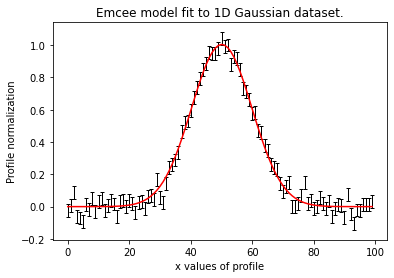

In [108]:
model_data = result.max_log_likelihood_instance.model_data_1d_via_xvalues_from(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", linestyle=" ", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Emcee model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.show()
plt.close()

__Samples__

Above, we used the `Result`'s `samples` property, which in this case is a `SamplesMCMC` object:

In [109]:
print(result.samples)

This object acts as an interface between the `Emcee` output results on your hard-disk and this Python code. For
example, we can use it to get the parameters and log likelihood of an accepted emcee sample.

In [110]:
print(result.samples.parameter_lists[10][:])
print(result.samples.log_likelihood_list[10])

[48.78800226163153, 1.7558631803366034, 12.791911142508868]
-4675.097798110116


The Probability Density Functions (PDF's) of the results can be plotted using the Emcee's visualization 
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

The PDF shows the 1D and 2D probabilities estimated for every parameter after the model-fit. The two dimensional 
figures can show the degeneracies between different parameters, for example how increasing $\sigma$ and decreasing 
the normalization $I$ can lead to similar likelihoods and probabilities.

2023-07-03 11:21:39,495 - root - WARNING - Too few points to create valid contours
2023-07-03 11:21:39,547 - root - WARNING - Too few points to create valid contours
2023-07-03 11:21:39,582 - root - WARNING - Too few points to create valid contours


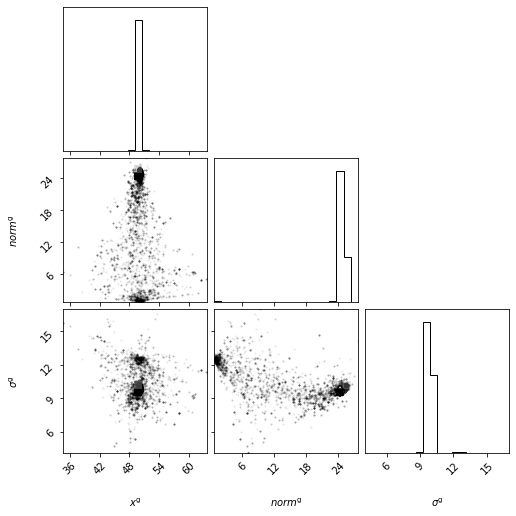

In [111]:
search_plotter = aplt.EmceePlotter(samples=result.samples)
search_plotter.corner()

A more detailed description of the `Result` object will be given in

__Wrap Up__

This tutorial introduced a lot of concepts: the parameter space, likelihood surface, non-linear search, priors, 
and much more. 

Make sure you are confident in your understanding of them, however the next tutorial will expand on them all.

Tutorial 4: Complex Models
==========================

In this tutorial, we will fix more complex models with N=10, N=20 and more parameters. We will consider the following:

 - Why more complex model are more difficult to fit, and may lead the non-linear search to incorrectly infer
   models with significantly lower likelihoods than the true maximum likelihood model.

 - Strategies for ensuring the non-linear search correctly estimates the maximum likelihood model.

 - What drives the run-times of a model-fit, and how one must carefully balance run-times with model complexity.
for mitigating this:

In [112]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import autofit.plot as aplt
from os import path
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Data__

We first load the dataset we will fit, which is a new `dataset` where the underlying signal is a sum of two  `Gaussian` 
profiles which share the same centre

In [113]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x2")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Plotting the data shows the noisy signal is more complicated than just a 1D Gaussian.

Note that both Gaussians are centred at the same point (x = 50). We will compose a model that reflects this.

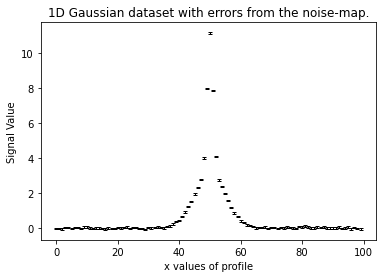

In [114]:
xvalues = np.arange(data.shape[0])
plt.errorbar(
    xvalues, data, yerr=noise_map, color="k", ecolor="k", linestyle=" ", elinewidth=1, capsize=2
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()

__Models__

We create the `Gaussian` class which will form our model components using the standard **PyAutoFit** format.

In [115]:


class Gaussian:
    def __init__(
            self,
            centre=30.0,  # <- **PyAutoFit** recognises these constructor arguments
            normalization=1.0,  # <- are the Gaussian`s model parameters.
            sigma=5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_1d_via_xvalues_from(self, xvalues: np.ndarray):
        """

        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


__Analysis__

We now define the  `Analysis` class for this model-fit. 

The `log_likelihood_function` of this analysis now assumes that the `instance` that is input into it will contain
multiple 1D profiles.

 The way the `model_data` is computed is updating accordingly (the sum of each individual Gaussian's `model_data`).

In [116]:


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):
        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):
        """
        Returns the log likelihood of the fit of an `instance` containing many 1D
        Profiles (e.g. Gaussians) to the dataset, using a model instance.

        Parameters
        ----------
        instance
            A list of 1D profiles with parameters set via the non-linear search.

        Returns
        -------
        float
            The log likelihood value indicating how well this model fit the `MaskedDataset`.
        """

        """
        In the previous tutorial the instance was a single `Gaussian` profile, meaning we could create the model data 
        using the line:

            model_data = instance.gaussian.model_data_1d_via_xvalues_from(xvalues=self.data.xvalues)

        In this tutorial our instance is comprised of multiple 1D Gaussians, because we will use a `Collection` to
        compose the model:

            model = Collection(gaussian_0=Gaussian, gaussian_1=Gaussian).

        By using a Collection, this means the instance parameter input into the fit function is a
        dictionary where individual profiles (and their parameters) can be accessed as followed:

            print(instance.gaussian_0)
            print(instance.gaussian_1)
            print(instance.gaussian_0.centre)

        In this tutorial, the `model_data` is therefore the summed `model_data` of all individual Gaussians in the 
        model. The function `model_data_from_instance` performs this summation. 
        """
        model_data = self.model_data_from_instance(instance=instance)

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood

    def model_data_from_instance(self, instance):
        """
        To create the summed profile of all individual profiles, we use a list comprehension to iterate over
        all profiles in the instance.

        The key point to understand is that the `instance` has the properties of a Python `iterator` and therefore
        can be looped over using the standard Python for syntax (e.g. `for profile in instance`).

        __Alternative Syntax__

        For those not familiar with list comprehensions, the code below shows how to use the instance to create the
        summed profile using a more simple for loop.

        model_data = np.zeros(shape=self.data.xvalues.shape[0])

        for profile in instance:
            model_data += profile.model_data_1d_via_xvalues_from(xvalues=self.data.xvalues)

        return model_data
        """
        xvalues = np.arange(self.data.shape[0])

        return sum(
            [
                profile.model_data_1d_via_xvalues_from(xvalues=xvalues)
                for profile in instance
            ]
        )


__Collection__

Use a `Collection` to compose the model we fit, consisting of two `Gaussian`'s.

In [117]:
model = af.Collection(gaussian_0=Gaussian, gaussian_1=Gaussian)

__Model Customization__

We can fully customize the model that we fit. 

First, lets align the centres of the two `Gaussian`'s (given we know they are aligned in the data). Note that
doing so reduces the number of free parameters in the model by 1, from N=6 to N=5.

Lets suppose we have a `dataset` that consists of three `Gaussian` 
profiles, but we also know the following information about the dataset:

- The 2 `Gaussian`'s are centrally aligned.
- The `sigma` of one `Gaussian` is equal to 1.0.
- The sigma of another `Gaussian` is above 3.0.

We can edit the `Model` components we pass into the `Collection` to meet these constraints accordingly.

Lets first create the model `Gaussian`'s as we did in the previous tutorial.

In [118]:
gaussian_0 = af.Model(Gaussian)
gaussian_1 = af.Model(Gaussian)

We can centrally align the two `Gaussian`'s by setting the `centre` of the first `Gaussian` to the `centre` of the
second `Gaussian`.

This removes a free parameter from the model reducing the dimensionality by 1 (from N=6 to N=5).

In [119]:
gaussian_0.centre = gaussian_1.centre

We can follow the same API to set the `sigma` of the first `Gaussian` to 1.0.

This again removes another free parameter from the model (from N=5 to N=4).

In [120]:
gaussian_0.sigma = 1.0

We can add assertions, for example requiring that  the `sigma` value of the second `Gaussian` is above 2.0.

Assertions do not change the dimensionality of the model, because we are not fixing or removing any free parameters.

In [121]:
gaussian_1.add_assertion(gaussian_1.sigma > 3.0)

We again input these newly customized model components into the `Collection`.

In [122]:
model = af.Collection(
    gaussian_0=gaussian_0,
    gaussian_1=gaussian_1,
)

The customized model can be printed via the `info` attribute, where the customizes discussed above can be seen.

In [123]:
print(model.info)

Total Free Parameters = 4

model                                                                           Collection (N=4)
    gaussian_0                                                                  Gaussian (N=2)
    gaussian_1                                                                  Gaussian (N=3)

gaussian_0
    centre                                                                      UniformPrior [76], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [74], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       1.0
gaussian_1
    centre                                                                      UniformPrior [76], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [77], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma

__Model Fit__

Lets now perform the fit using our model which is composed of two profile's in a non-linear parameter space of
dimensionality N=4.

In [124]:
analysis = Analysis(data=data, noise_map=noise_map)

search = af.Emcee(name="session_1")

print(
    "Emcee has begun running. \n"
    "This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!"
)

result = search.fit(model=model, analysis=analysis)

print("Emcee has finished run - you may now continue the notebook.")

2023-07-03 11:21:41,981 - autofit.non_linear.abstract_search - INFO - Creating search
Emcee has begun running. 
This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
2023-07-03 11:21:41,983 - session_1 - INFO - Starting search
2023-07-03 11:21:42,178 - session_1 - INFO - Already completed, skipping non-linear search.
2023-07-03 11:21:47,167 - session_1 - INFO - Removing zip file
Emcee has finished run - you may now continue the notebook.


__Result__

The `info` attribute shows the result in a readable format, which contains informaiton on the full collection
of model components.

In [125]:
print(result.info)

Maximum Log Likelihood                                                          189.29105789
Maximum Log Posterior                                                           189.36610439

model                                                                           Collection (N=4)
    gaussian_0                                                                  Gaussian (N=2)
    gaussian_1                                                                  Gaussian (N=3)

Maximum Log Likelihood Model:

gaussian_0
    normalization                                                               19.943
gaussian_1
    centre                                                                      49.996
    normalization                                                               40.153
    sigma                                                                       5.010


Summary (3.0 sigma limits):

gaussian_0
    normalization                                                               19.

__Failure__

In this example, every fit to the noisy 1D signal was a good fit, based on the fit looking visually close to the data.

For modeling in general, however, things are not always so simple. It is common for the model-fit to provide a bad fit to the data.
Furthermore, it can be difficult to determine if this is because the model is genuinely a poor fit or because the non-linear search (e.g. `emcee`)
failed sample parameter space robustly enough to locate the highest likelihood regions of parameter space. The next session will illustrate an example of this.

When a non-linear search infers a lower likelihood solution than the highest likelihood solutions that exist in the parameter space, called
the "global maximum likelihood", it is said to have become trapped by a "local maximum". There is no simple way to determine if a non-linear has
done this. The process typically involves visually inspecting the results, fitting the model many times (ideally with different models, non-linear searches and settings) and building up intuition for your modeling problem as to how things behave and when they work / do not work.

Owing to the model-specific nature of this problem, these lectures will only briefly illustrate model-fitting failures and how one might overcome them.
If you embark on your own model-fitting endeavours, this will be the aspect of model-fitting you will have to learn about yourself!


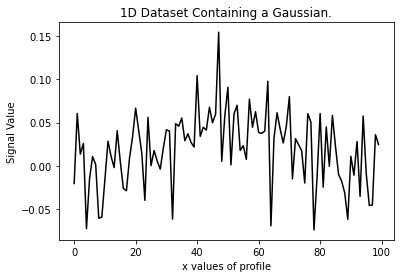

In [128]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x2__offset_centres", "dataset_0")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))

noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Dataset Containing a Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()

In [ ]:
__Wrap Up__

And with that, we are complete. In this tutorial, we learned how to compose and fit complex models in **PyAutoFit**.

To end, you should think again in more detail about your model fitting problem:

 Are there many different model components you may wish to define and fit?

 Is your data the super position of many different model components, like the profiles in this tutorial?

 In this tutorial, all components of our model did the same thing, represent a 1D profile. In your model, you may
have model components that represent different parts of your model, which need to be combined in more complicated ways
in order to create your model-fit. You now have all the tools you need to define, compose and fit very complex models!